In [ ]:
import pandas as pd

pxc50 = pd.read_csv("data/pivoted_pXC50_over_1000_split.csv")
pxc50_train = pxc50[pxc50["split"] == "train"]

pxc50

In [ ]:
# Knowledge distillation
from assessment.chemprop_callback import chemprop_single_target_callback

targets = pxc50_train.drop(columns=["SMILES", "split"]).columns
target_predictions = chemprop_single_target_callback(pxc50_train, targets, verbose=True, dropna=False)

target_predictions

In [3]:
pxc50_train_distilled = pxc50_train.copy()
for target in targets:
    predicted_activity = pd.Series(target_predictions[target], index=pxc50_train.index)
    pxc50_train_distilled[target] = pxc50_train_distilled[target].fillna(predicted_activity)

pxc50_distilled = pd.concat([
    pxc50_train_distilled,
    pxc50[pxc50["split"] == "val"],
    pxc50[pxc50["split"] == "test"],
])
pxc50_distilled.to_csv("data/pivoted_pXC50_over_1000_split_distilled.csv", index=False)

In [4]:
import pickle

with open("data/pXC50_over_1000_target_predictions_train.pkl", "wb") as f:
    pickle.dump(target_predictions, f)

In [1]:
import pickle
import pandas as pd
import numpy as np

# Load distilled data
pxc50_distilled = pd.read_csv("data/pivoted_pXC50_over_1000_split_distilled.csv")
pxc50_train_distilled = pxc50_distilled[pxc50_distilled["split"] == "train"]

# Load target predictions
with open("data/pXC50_over_1000_target_predictions_train.pkl", "rb") as f:
    target_predictions = pickle.load(f)

In [2]:
import numpy as np
from scipy.stats import pearsonr

# Get list of targets (excluding SMILES and split columns)
targets = pxc50_train_distilled.drop(columns=["SMILES", "split"]).columns
n_targets = len(targets)

# Initialize correlation matrix
correlation_matrix = np.zeros((n_targets, n_targets))

# Calculate correlations between all pairs of targets
for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        correlation_matrix[i,j] = pearsonr(
            pxc50_train_distilled[target1],
            pxc50_train_distilled[target2]
        )[0]

# Create DataFrame for better visualization
correlation_df = pd.DataFrame(
    correlation_matrix,
    index=targets,
    columns=targets
)

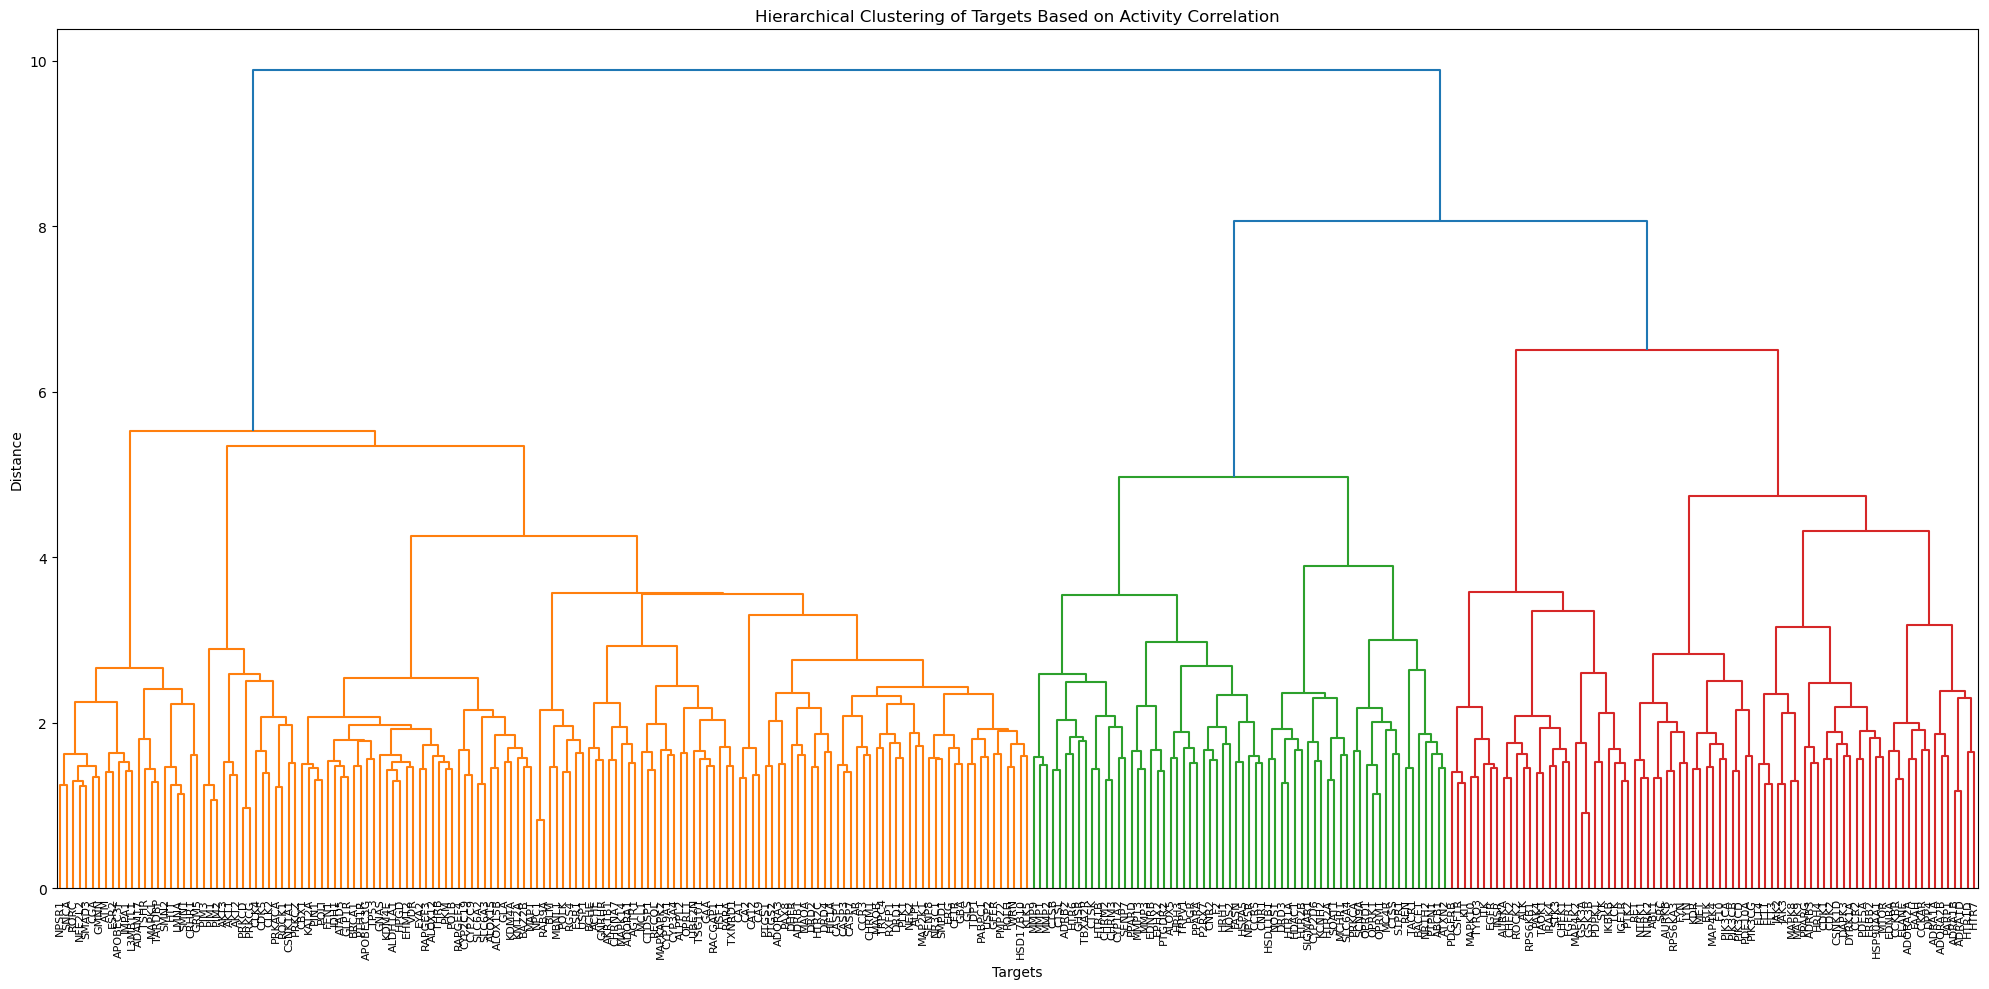

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

condensed_distance_matrix = pdist(correlation_df.abs(), metric='euclidean')
linkage_matrix = linkage(condensed_distance_matrix, method='ward')

plt.figure(figsize=(20, 10))
dendrogram(
    linkage_matrix,
    labels=correlation_df.index,
    leaf_rotation=90,  # Rotate labels for better readability
    leaf_font_size=8   # Adjust font size if needed
)

plt.title('Hierarchical Clustering of Targets Based on Activity Correlation')
plt.xlabel('Targets')
plt.ylabel('Distance')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

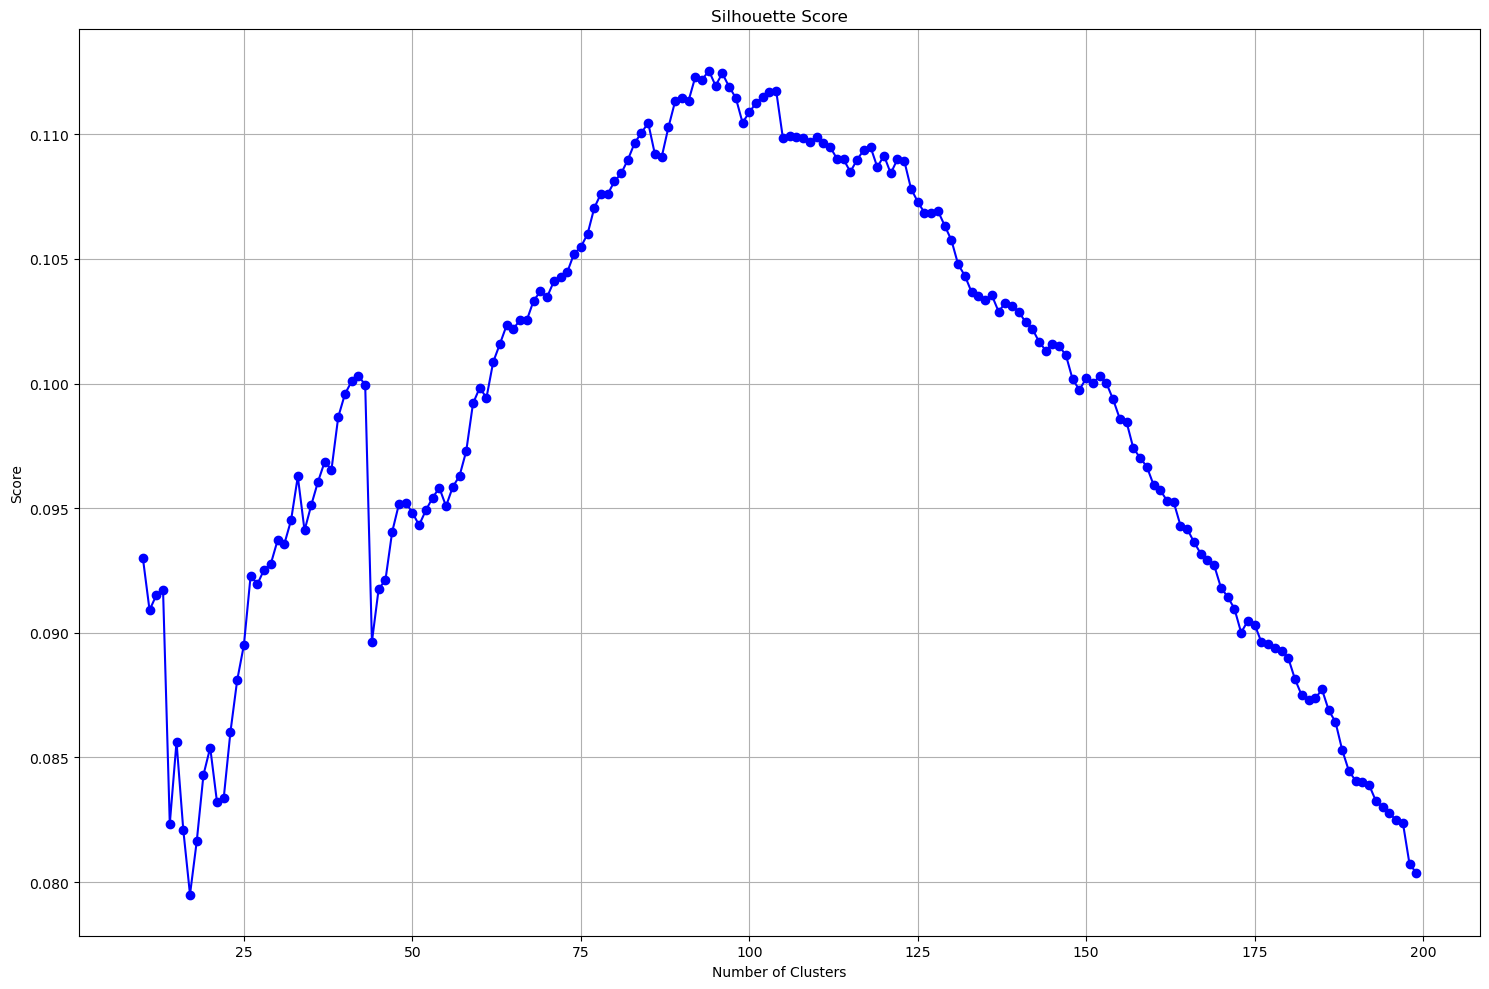


Optimal number of clusters based on:
Silhouette Score: 94 clusters


In [ ]:
# Import required libraries for cluster evaluation
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*looks suspiciously like an uncondensed distance matrix.*")


# Convert condensed distance matrix back to full distance matrix
distance_matrix = squareform(condensed_distance_matrix)

def evaluate_clustering(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(data)
    
    silhouette = silhouette_score(data, labels)
    return {'silhouette': silhouette}

n_clusters_range = range(10, 200)
metrics = {}

for n_clusters in n_clusters_range:
    metrics[n_clusters] = evaluate_clustering(distance_matrix, n_clusters)

# Plot the results
plt.figure(figsize=(9, 6))

# Plot 1: Silhouette Score
plt.plot(list(metrics.keys()), [m['silhouette'] for m in metrics.values()], 'bo-')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.grid(True)

plt.tight_layout()
plt.show()

best_n_clusters = max(metrics.items(), key=lambda x: x[1]['silhouette'])[0]
print(f"Optimal number of clusters based on silhouette Score: {best_n_clusters} clusters")

In [13]:
# You can also get cluster assignments for a specific number of clusters
n_clusters = best_n_clusters
clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = clustering.fit_predict(distance_matrix)

target_clusters = dict(zip(correlation_df.index, cluster_labels.astype(int)))

In [14]:
clusters = dict()

for target, cluster in target_clusters.items():
    cluster = int(cluster)
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(target)

target_clusters = {str(k): int(v) for k, v in target_clusters.items()}
clusters_and_targets = {
    "cluster_to_targets": clusters,
    "targets_to_cluster": target_clusters,
}

In [15]:
# Save the clusters and targets mapping as JSON
import json
from pathlib import Path

data_path = Path("./data")
output_file = data_path / "target_clusters_correlation.json"

with open(output_file, "w") as f:
    json.dump(clusters_and_targets, f, indent=2, ensure_ascii=False)